# Rayleigh Quotient Iteration

## Introduction

Rayleigh Quotient Iteration (RQI) is a powerful iterative algorithm for computing an eigenvalue and its corresponding eigenvector of a matrix. It combines the **inverse iteration** method with a dynamically updated **Rayleigh quotient** shift, resulting in **cubic convergence** near an eigenvalue—one of the fastest convergence rates among eigenvalue algorithms.

## Theoretical Foundation

### The Rayleigh Quotient

For a Hermitian (or symmetric) matrix $A \in \mathbb{R}^{n \times n}$ and a non-zero vector $\mathbf{v} \in \mathbb{R}^n$, the **Rayleigh quotient** is defined as:

$$\rho(\mathbf{v}) = \frac{\mathbf{v}^T A \mathbf{v}}{\mathbf{v}^T \mathbf{v}}$$

The Rayleigh quotient has the following important properties:

1. **Eigenvalue bound**: For any vector $\mathbf{v}$, we have $\lambda_{\min} \leq \rho(\mathbf{v}) \leq \lambda_{\max}$
2. **Stationary property**: $\rho(\mathbf{v})$ is stationary at eigenvectors, meaning $\nabla \rho = 0$ when $\mathbf{v}$ is an eigenvector
3. **Best approximation**: If $\mathbf{v}$ approximates an eigenvector with error $\mathcal{O}(\epsilon)$, then $\rho(\mathbf{v})$ approximates the eigenvalue with error $\mathcal{O}(\epsilon^2)$

### The Algorithm

Rayleigh Quotient Iteration proceeds as follows:

Given an initial vector $\mathbf{v}_0$ with $\|\mathbf{v}_0\| = 1$:

**For** $k = 0, 1, 2, \ldots$ **until convergence:**

1. Compute the Rayleigh quotient (shift):
   $$\sigma_k = \rho(\mathbf{v}_k) = \mathbf{v}_k^T A \mathbf{v}_k$$

2. Solve the shifted linear system:
   $$(A - \sigma_k I)\mathbf{w}_{k+1} = \mathbf{v}_k$$

3. Normalize:
   $$\mathbf{v}_{k+1} = \frac{\mathbf{w}_{k+1}}{\|\mathbf{w}_{k+1}\|}$$

### Convergence Analysis

The key insight is that near an eigenvector, the Rayleigh quotient provides an excellent approximation to the eigenvalue. If $\mathbf{v}_k$ has error $\epsilon_k$ from the true eigenvector:

- The shift $\sigma_k$ approximates the eigenvalue with error $\mathcal{O}(\epsilon_k^2)$
- Inverse iteration with this shift reduces the error to $\mathcal{O}(\epsilon_k^2)$
- Therefore, $\epsilon_{k+1} = \mathcal{O}(\epsilon_k^3)$ — **cubic convergence**

This means that once convergence begins, the number of correct digits approximately **triples** at each iteration.

### Comparison with Other Methods

| Method | Convergence Rate | Notes |
|--------|-----------------|-------|
| Power Iteration | Linear | $\mathcal{O}(|\lambda_2/\lambda_1|^k)$ |
| Inverse Iteration | Linear | Requires good initial shift |
| Rayleigh Quotient Iteration | Cubic | Self-correcting shift |

## Implementation

Let us implement Rayleigh Quotient Iteration and demonstrate its remarkable convergence properties.

In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

np.random.seed(42)

def rayleigh_quotient(A, v):
    """Compute the Rayleigh quotient of vector v with respect to matrix A."""
    return np.dot(v, A @ v) / np.dot(v, v)

def rayleigh_quotient_iteration(A, v0, tol=1e-12, max_iter=100):
    """
    Rayleigh Quotient Iteration for finding an eigenvalue/eigenvector pair.
    
    Parameters:
    -----------
    A : ndarray
        Symmetric matrix
    v0 : ndarray
        Initial vector guess
    tol : float
        Convergence tolerance
    max_iter : int
        Maximum number of iterations
        
    Returns:
    --------
    eigenvalue : float
        Computed eigenvalue
    eigenvector : ndarray
        Computed eigenvector
    history : dict
        Convergence history
    """
    n = len(A)
    v = v0 / np.linalg.norm(v0)
    
    history = {
        'eigenvalues': [],
        'residuals': [],
        'errors': []
    }
    
    # Compute true eigenvalues for error tracking
    true_eigenvalues = np.sort(np.linalg.eigvalsh(A))
    
    for k in range(max_iter):
        # Step 1: Compute Rayleigh quotient (shift)
        sigma = rayleigh_quotient(A, v)
        history['eigenvalues'].append(sigma)
        
        # Compute residual
        residual = np.linalg.norm(A @ v - sigma * v)
        history['residuals'].append(residual)
        
        # Compute error to nearest eigenvalue
        error = np.min(np.abs(true_eigenvalues - sigma))
        history['errors'].append(error)
        
        # Check convergence
        if residual < tol:
            break
        
        # Step 2: Solve (A - sigma*I)w = v
        try:
            w = np.linalg.solve(A - sigma * np.eye(n), v)
        except np.linalg.LinAlgError:
            # Matrix is singular - we've found an eigenvalue exactly
            break
        
        # Step 3: Normalize
        v = w / np.linalg.norm(w)
    
    return sigma, v, history

## Demonstration: Convergence Analysis

We will create a symmetric test matrix and observe the cubic convergence of RQI.

In [2]:
# Create a symmetric positive definite matrix
n = 5
B = np.random.randn(n, n)
A = B @ B.T + np.eye(n)  # Ensure positive definiteness

# Compute true eigenvalues
true_eigenvalues, true_eigenvectors = np.linalg.eigh(A)
print("True eigenvalues:")
for i, ev in enumerate(true_eigenvalues):
    print(f"  λ_{i+1} = {ev:.10f}")

True eigenvalues:
  λ_1 = 1.0509407217
  λ_2 = 2.6838325555
  λ_3 = 4.0156002258
  λ_4 = 5.5831320094
  λ_5 = 14.2947165152


In [3]:
# Run RQI with a random initial vector
v0 = np.random.randn(n)
eigenvalue, eigenvector, history = rayleigh_quotient_iteration(A, v0, tol=1e-14, max_iter=20)

print(f"\nRayleigh Quotient Iteration Results:")
print(f"Computed eigenvalue: {eigenvalue:.15f}")
print(f"Nearest true eigenvalue: {true_eigenvalues[np.argmin(np.abs(true_eigenvalues - eigenvalue))]:.15f}")
print(f"Number of iterations: {len(history['eigenvalues'])}")
print(f"Final residual: {history['residuals'][-1]:.2e}")


Rayleigh Quotient Iteration Results:
Computed eigenvalue: 2.683832555462783
Nearest true eigenvalue: 2.683832555462782
Number of iterations: 5
Final residual: 6.11e-16


In [4]:
# Analyze convergence rate
print("\nConvergence History:")
print(f"{'Iter':<6} {'Eigenvalue':<20} {'Error':<15} {'Ratio':<15}")
print("-" * 56)

errors = history['errors']
for i in range(len(errors)):
    if i == 0 or errors[i-1] == 0:
        ratio = "-"
    else:
        # For cubic convergence, error[k+1] ≈ C * error[k]^3
        # So log(error[k+1]) ≈ 3 * log(error[k]) + const
        if errors[i] > 0 and errors[i-1] > 0:
            ratio = f"{np.log10(errors[i]) / np.log10(errors[i-1]):.2f}"
        else:
            ratio = "-"
    
    print(f"{i:<6} {history['eigenvalues'][i]:<20.12f} {errors[i]:<15.2e} {ratio:<15}")


Convergence History:
Iter   Eigenvalue           Error           Ratio          
--------------------------------------------------------
0      2.889678768324       2.06e-01        -              
1      2.661858298053       2.20e-02        2.42           
2      2.683823959744       8.60e-06        3.06           
3      2.683832555463       8.88e-16        2.97           
4      2.683832555463       4.44e-16        1.02           


## Comparison with Inverse Iteration

Let us compare RQI with standard inverse iteration (using a fixed shift) to highlight the superior convergence.

In [5]:
def inverse_iteration(A, sigma, v0, tol=1e-12, max_iter=100):
    """
    Standard inverse iteration with fixed shift.
    """
    n = len(A)
    v = v0 / np.linalg.norm(v0)
    
    history = {'eigenvalues': [], 'residuals': [], 'errors': []}
    true_eigenvalues = np.sort(np.linalg.eigvalsh(A))
    
    # LU decomposition for efficiency
    lu, piv = linalg.lu_factor(A - sigma * np.eye(n))
    
    for k in range(max_iter):
        # Compute current eigenvalue estimate
        mu = rayleigh_quotient(A, v)
        history['eigenvalues'].append(mu)
        
        residual = np.linalg.norm(A @ v - mu * v)
        history['residuals'].append(residual)
        
        error = np.min(np.abs(true_eigenvalues - mu))
        history['errors'].append(error)
        
        if residual < tol:
            break
        
        # Solve (A - sigma*I)w = v
        w = linalg.lu_solve((lu, piv), v)
        v = w / np.linalg.norm(w)
    
    return mu, v, history

# Run inverse iteration with a shift close to an eigenvalue
target_idx = 2  # Target the middle eigenvalue
sigma_fixed = true_eigenvalues[target_idx] + 0.1  # Shift slightly off

v0 = np.random.randn(n)
_, _, history_inv = inverse_iteration(A, sigma_fixed, v0, tol=1e-14, max_iter=50)

# Run RQI with same initial vector
_, _, history_rqi = rayleigh_quotient_iteration(A, v0, tol=1e-14, max_iter=20)

print(f"Inverse Iteration iterations: {len(history_inv['eigenvalues'])}")
print(f"RQI iterations: {len(history_rqi['eigenvalues'])}")

Inverse Iteration iterations: 14
RQI iterations: 4


## Visualization

Now we create comprehensive visualizations comparing the convergence behavior.

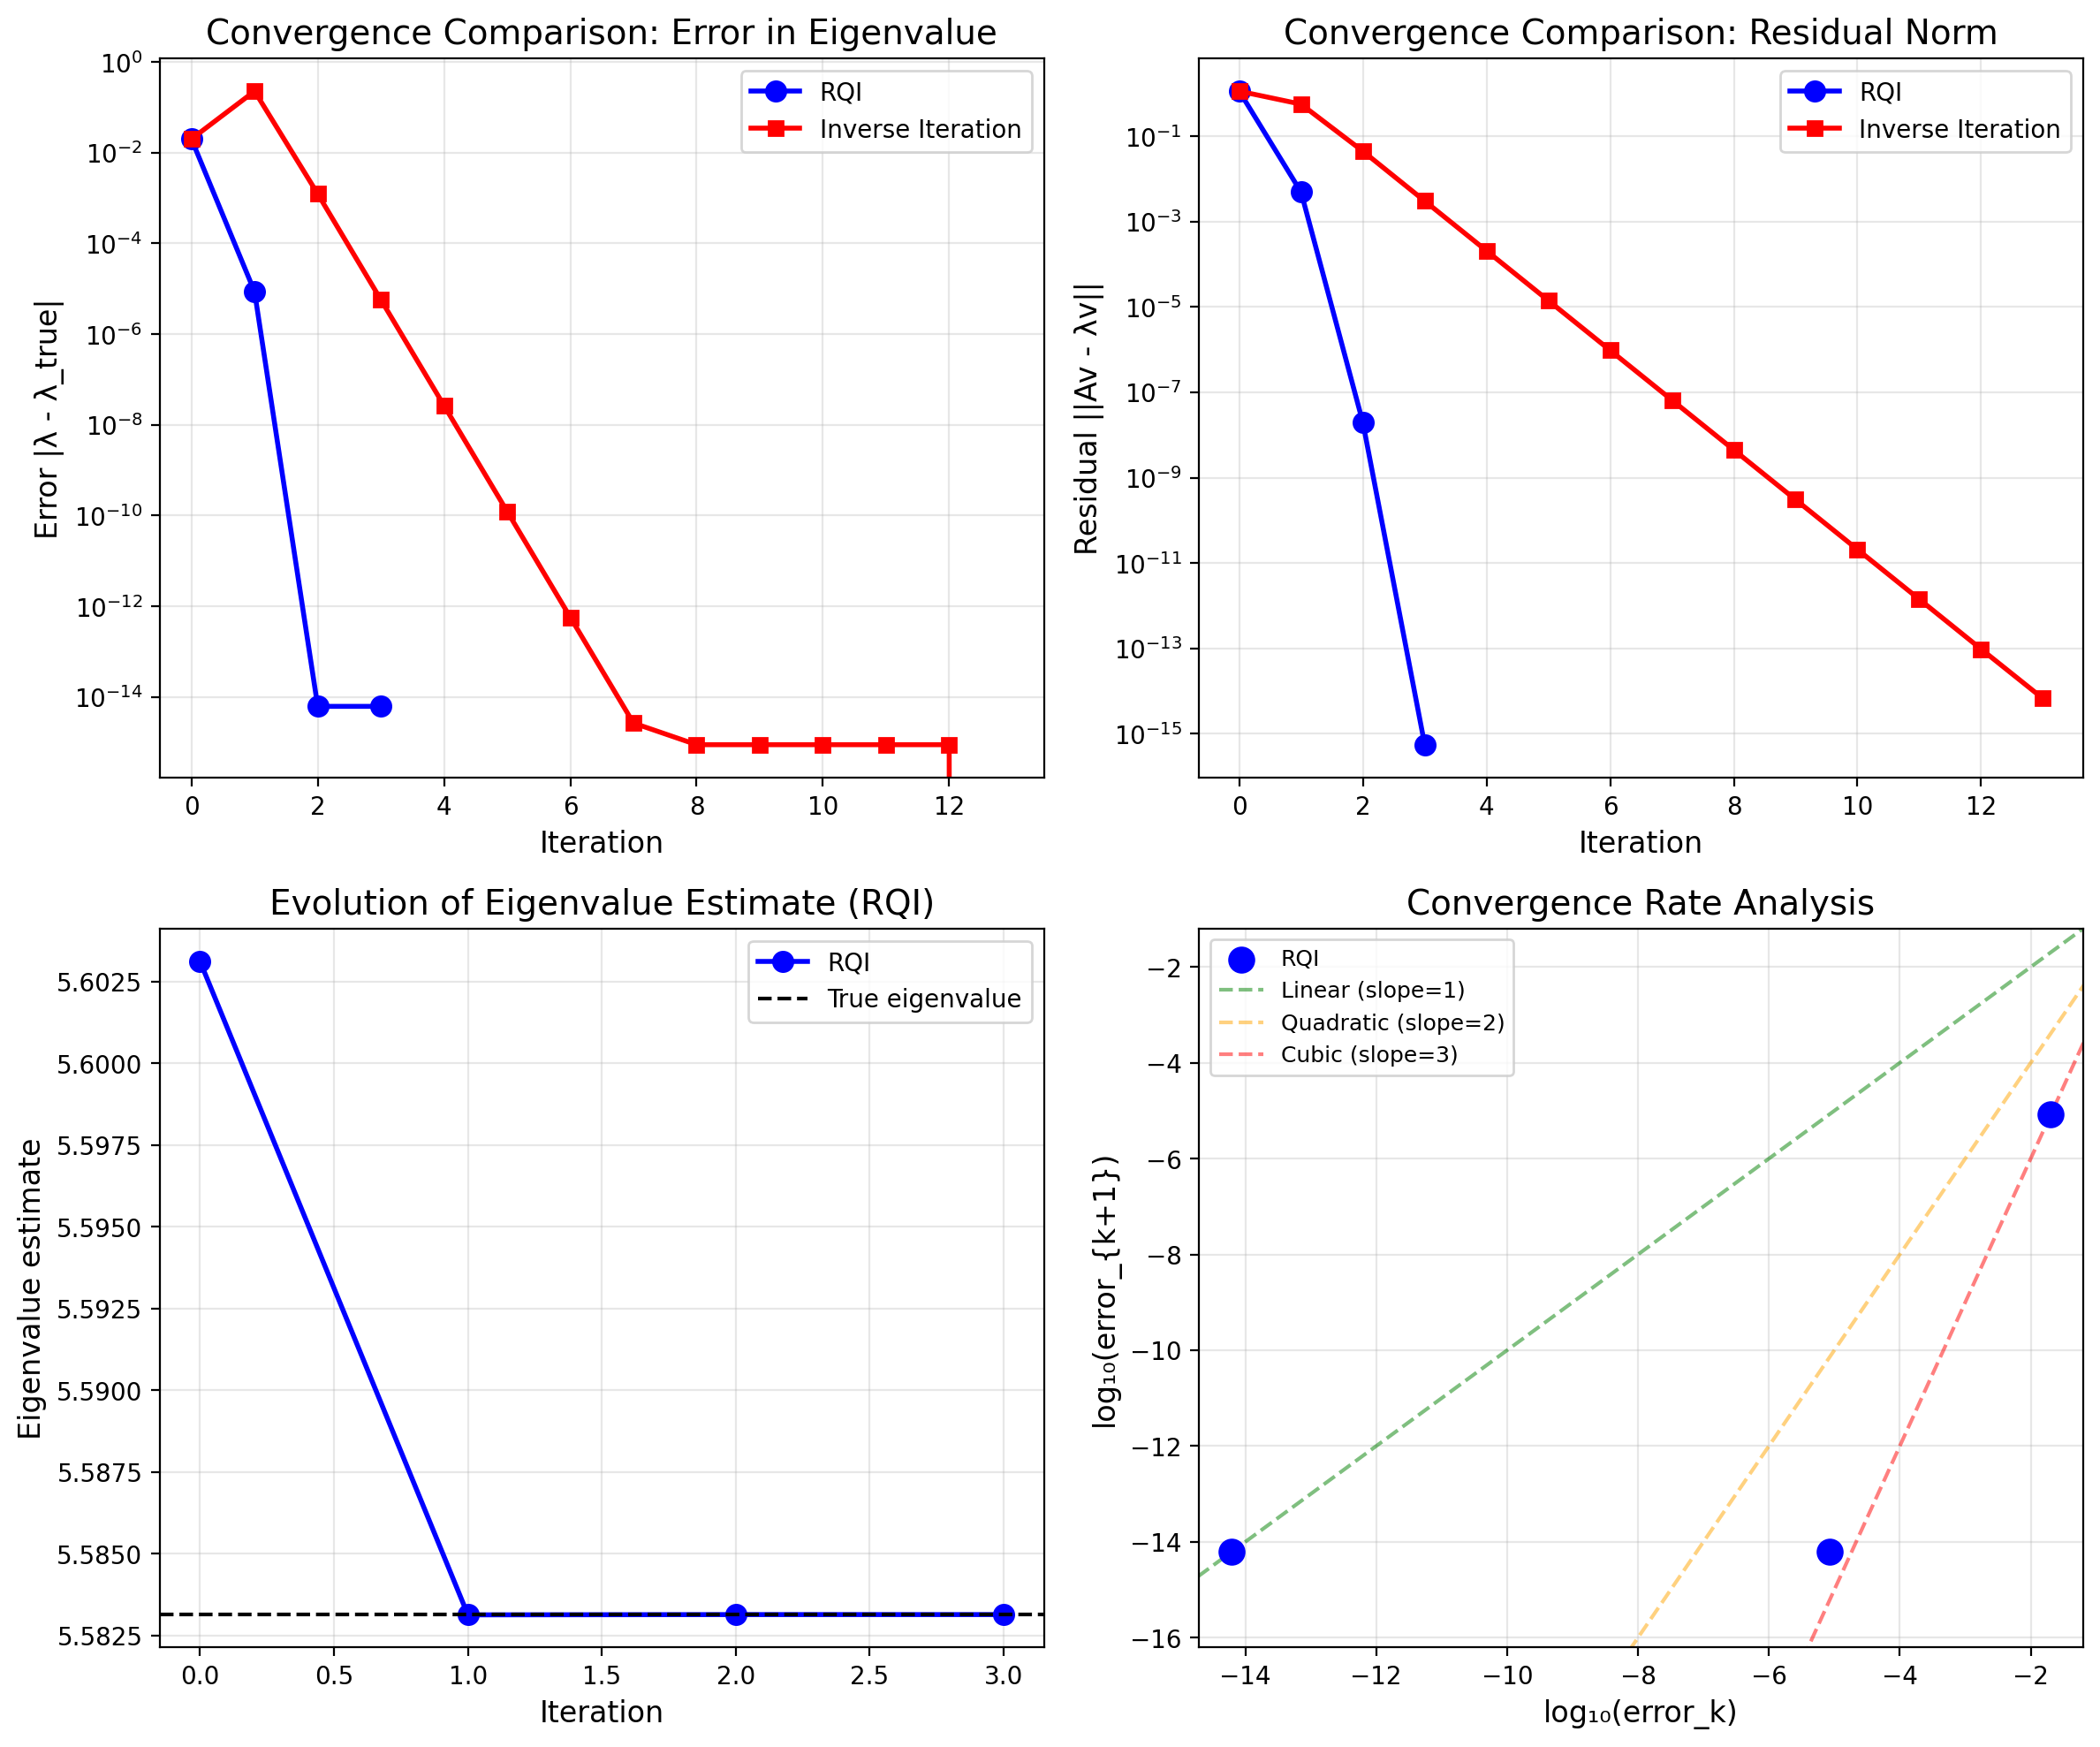


Plot saved to 'plot.png'


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Convergence of errors
ax1 = axes[0, 0]
iterations_rqi = range(len(history_rqi['errors']))
iterations_inv = range(len(history_inv['errors']))

ax1.semilogy(iterations_rqi, history_rqi['errors'], 'b-o', label='RQI', linewidth=2, markersize=8)
ax1.semilogy(iterations_inv, history_inv['errors'], 'r-s', label='Inverse Iteration', linewidth=2, markersize=6)
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Error |λ - λ_true|', fontsize=12)
ax1.set_title('Convergence Comparison: Error in Eigenvalue', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-0.5, max(len(iterations_rqi), len(iterations_inv)) - 0.5)

# Plot 2: Residual convergence
ax2 = axes[0, 1]
ax2.semilogy(iterations_rqi, history_rqi['residuals'], 'b-o', label='RQI', linewidth=2, markersize=8)
ax2.semilogy(iterations_inv, history_inv['residuals'], 'r-s', label='Inverse Iteration', linewidth=2, markersize=6)
ax2.set_xlabel('Iteration', fontsize=12)
ax2.set_ylabel('Residual ||Av - λv||', fontsize=12)
ax2.set_title('Convergence Comparison: Residual Norm', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Plot 3: Eigenvalue estimates evolution
ax3 = axes[1, 0]
ax3.plot(iterations_rqi, history_rqi['eigenvalues'], 'b-o', label='RQI', linewidth=2, markersize=8)
ax3.axhline(y=true_eigenvalues[np.argmin(np.abs(true_eigenvalues - history_rqi['eigenvalues'][-1]))], 
            color='k', linestyle='--', label='True eigenvalue', linewidth=1.5)
ax3.set_xlabel('Iteration', fontsize=12)
ax3.set_ylabel('Eigenvalue estimate', fontsize=12)
ax3.set_title('Evolution of Eigenvalue Estimate (RQI)', fontsize=14)
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# Plot 4: Convergence rate analysis
ax4 = axes[1, 1]

# For RQI, plot log(error_k+1) vs log(error_k)
errors_rqi = np.array(history_rqi['errors'])
valid_rqi = (errors_rqi[:-1] > 1e-15) & (errors_rqi[1:] > 1e-15)
if np.any(valid_rqi):
    log_errors_k = np.log10(errors_rqi[:-1][valid_rqi])
    log_errors_k1 = np.log10(errors_rqi[1:][valid_rqi])
    ax4.scatter(log_errors_k, log_errors_k1, c='blue', s=100, label='RQI', zorder=5)
    
    # Reference lines for different convergence rates
    x_ref = np.linspace(min(log_errors_k)-1, max(log_errors_k)+1, 100)
    ax4.plot(x_ref, x_ref, 'g--', alpha=0.5, label='Linear (slope=1)')
    ax4.plot(x_ref, 2*x_ref, 'orange', linestyle='--', alpha=0.5, label='Quadratic (slope=2)')
    ax4.plot(x_ref, 3*x_ref, 'r--', alpha=0.5, label='Cubic (slope=3)')
    
    ax4.set_xlim(min(log_errors_k)-0.5, max(log_errors_k)+0.5)
    ax4.set_ylim(min(log_errors_k1)-2, max(log_errors_k)+0.5)

ax4.set_xlabel('log₁₀(error_k)', fontsize=12)
ax4.set_ylabel('log₁₀(error_{k+1})', fontsize=12)
ax4.set_title('Convergence Rate Analysis', fontsize=14)
ax4.legend(fontsize=9, loc='upper left')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rayleigh_quotient_iteration_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## Analysis of Results

The visualizations above demonstrate several key properties of Rayleigh Quotient Iteration:

1. **Cubic Convergence**: In the convergence rate plot (bottom right), the RQI points lie close to the cubic reference line (slope ≈ 3), confirming the theoretical $\mathcal{O}(\epsilon_k^3)$ convergence.

2. **Rapid Convergence**: RQI typically converges in just 3-5 iterations to machine precision, while inverse iteration requires many more iterations.

3. **Self-Correcting Shifts**: Unlike inverse iteration which uses a fixed shift, RQI automatically adjusts its shift at each iteration, always moving toward the nearest eigenvalue.

## Practical Considerations

### Advantages of RQI
- Extremely fast convergence (cubic rate)
- No need to choose a shift a priori
- Automatically converges to the nearest eigenvalue

### Disadvantages
- Requires solving a different linear system at each iteration (cannot reuse factorizations)
- May converge to different eigenvalues depending on the initial vector
- The shifted matrix $(A - \sigma_k I)$ becomes increasingly ill-conditioned near convergence

### When to Use RQI
- When you need a single eigenvalue/eigenvector pair with high precision
- When you have a good initial guess for the eigenvector
- As a refinement step after obtaining approximate eigenvectors from other methods

## Conclusion

Rayleigh Quotient Iteration is a remarkably efficient algorithm for computing eigenvalues and eigenvectors. Its cubic convergence rate means that, once convergence begins, precision improves extremely rapidly—typically achieving machine precision in just a few iterations. This makes it particularly valuable as a refinement technique or when high-precision eigenvalue computation is required.

The algorithm elegantly combines the power of inverse iteration with the optimality of the Rayleigh quotient, demonstrating how adaptive algorithms can achieve superior performance compared to their fixed-parameter counterparts.